In [one of my previous blog posts](https://nicoleeic.github.io/Brain_and_Code/2019/09/01/Hypothesis_tests.html) I talked about how to pick the right statistical hypothesis test for your experimental design. One of the most heavily used family of tests for psychological and in general for experimental research is Analysis of Variance (ANOVA). Most analysis frameworks have built-in implementations for ANOVAs -- with different strengths and limitations. But in order to set up and interpret your ANOVA correctly, it is necessary to understand it in the more general context of linear models and linear regression.

Here, I wrote a tutorial of how to conduct an ANOVA in Python and R and how to assess the underlying models matrices. Note that I didn't include the assumption checks or post-hoc tests that you would typically want to do. Furthermore, the examples below include 3 and 4-factorial ANOVAs to demonstrate the underlying principles, but in practice you might want to break down your design. Such 'big' ANOVAs are not recommended, because they don't account for the multiple tests involved. 

This tutorial is also accessible as interactive Jupyter Notebook in two parts: First part with Python kernel and second part with R kernel. All code for the examples below can also be found [in my GitHub repository](https://github.com/NicoleEic/Brain_and_Code/tree/master/neuro_scripts/GLM_demo).

The imports that I used for all Python code below are the following:

In [1]:
import os
import random
import numpy as np
import pandas as pd
import patsy
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.anova import AnovaRM
from statsmodels.regression.mixed_linear_model import MixedLMResults
from scipy import stats
import seaborn as sns

# 1-way ANOVA in Python (between-subject factor)
Let's start with an example, where we are comparing an outcome measure in three different groups of subjects (healthy controls and two groups of patients, 10 subjects per group). Here, I'm simulating data with an effect of group and plot the data to inspect it.

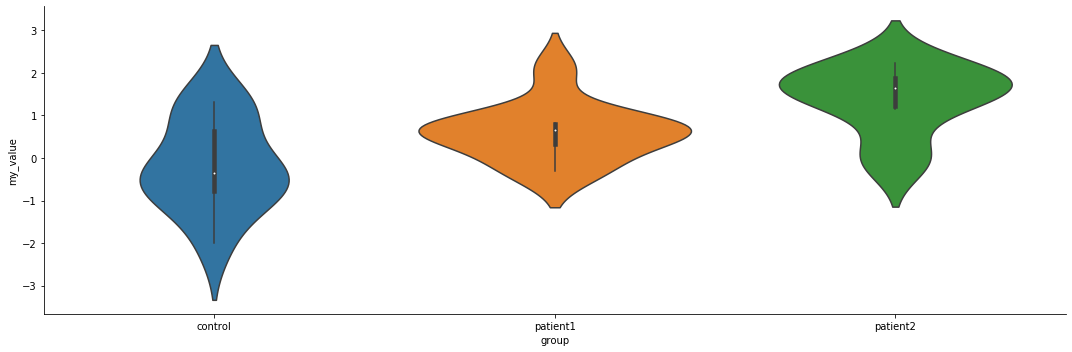

In [2]:
# information on experimental design
group_list = ['control','patient1','patient2']
subs_list = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10']

# read data into dataframe
df_1way = pd.DataFrame(columns=["group", "my_value"])
my_row = 0
for ind_g, group in enumerate(group_list):
    for sub in subs_list:
        # generate random value here as example
        my_val = np.random.normal(ind_g, 1, 1)[0]
        df_1way.loc[my_row] = [group, my_val]
        my_row = my_row + 1

# inspect data
sns.catplot(x="group", y="my_value", data=df_1way, dodge=True, kind='violin', aspect=3)
plt.show()

In order to conduct an ANOVA, we need to need to perform three steps: 1) Generate a model that fits our design, 2) Fit our data to the model to obtain the parameter estimates, 3) Derive the statistics using a summary function of the model fit. In Python, these steps are implemented in the `statsmodels` library. The general function to perform a linear regression (which is underlying an ANOVA) is `ols`. You can specify your model for `ols` using the same formula syntax that is used in R. If you conduct a 1-way ANOVA, i.e. you only have one categorical factor in your design, you can also use the `f_oneway` function. If you run the code below, you will see that they give an identical result

In [3]:
# generate model for linear regression
my_model = smf.ols(formula='my_value ~ group', data=df_1way)

# fit model to data to obtain parameter estimates
my_model_fit = my_model.fit()

# print summary of linear regression
print(my_model_fit.summary())

# show anova table
anova_table = sm.stats.anova_lm(my_model_fit, typ=2)
print(anova_table)

                            OLS Regression Results                            
Dep. Variable:               my_value   R-squared:                       0.378
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                     8.220
Date:                Sun, 03 Nov 2019   Prob (F-statistic):            0.00163
Time:                        11:53:16   Log-Likelihood:                -36.303
No. Observations:                  30   AIC:                             78.61
Df Residuals:                      27   BIC:                             82.81
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.1754      0.27

In [4]:
# compare p-value to f_oneway analysis
F, p = stats.f_oneway(df_1way[df_1way['group'] == 'control'].my_value, df_1way[df_1way['group'] == 'patient1'].my_value, df_1way[df_1way['group'] == 'patient2'].my_value)
print(p)

0.0016293255849487813


# 2-way ANOVA in Python (between-subject factors)
___
In the next example, we are extending our design to include native language of the subjects as additional factor. This means that we are still in a fully between-subject design and each data point comes from a different subject. The function call to `ols` with the `*` operator will model both main effects for group and language and their interaction.

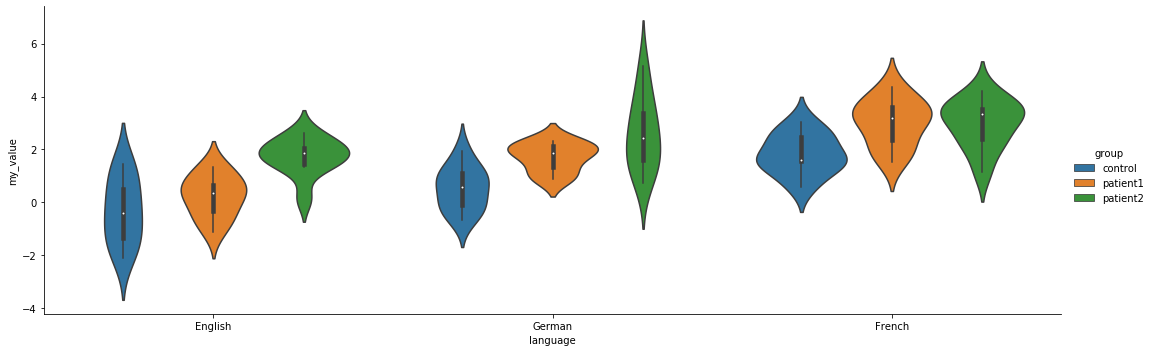

In [5]:
# information on experimental design
group_list = ['control','patient1','patient2']
language_list = ['English', 'German', 'French']
subs_list = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10']

# read data into dataframe
df_2way = pd.DataFrame(columns=["group", "language", "my_value"])
my_row = 0
for ind_g, group in enumerate(group_list):
    for ind_l, lan in enumerate(language_list):
        for sub in subs_list:
                # generate random value here as example
                my_val = np.random.normal(ind_g + ind_l, 1, 1)[0]
                df_2way.loc[my_row] = [group, lan, my_val]
                my_row = my_row + 1


# plot data
sns.catplot(x="language", y="my_value", data=df_2way, dodge=True, hue='group', kind='violin', aspect=3)
plt.show()

In [6]:
# fit model to data to obtain parameter estimates
my_model_fit = smf.ols(formula='my_value ~ group * language', data=df_2way).fit()
# print summary of linear regression
print(my_model_fit.summary())
# show anova table
print(sm.stats.anova_lm(my_model_fit, typ=2))

                            OLS Regression Results                            
Dep. Variable:               my_value   R-squared:                       0.630
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     17.25
Date:                Sun, 03 Nov 2019   Prob (F-statistic):           1.07e-14
Time:                        11:53:17   Log-Likelihood:                -115.57
No. Observations:                  90   AIC:                             249.1
Df Residuals:                      81   BIC:                             271.6
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


## Patsy
At this point I would like to mention that `statsmodels` internally uses the `patsy` library to convert the specified formula to a model matrix. This is useful, because we can access and visualize the underlying model matrix. You can modify the design matrix, for example, to change the coding scheme for factorial categories from 'treatment' to 'sum' or use a different reference level.

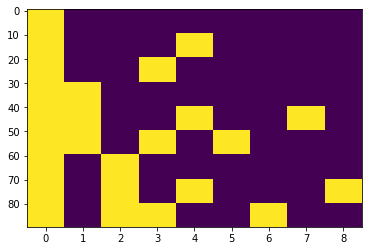

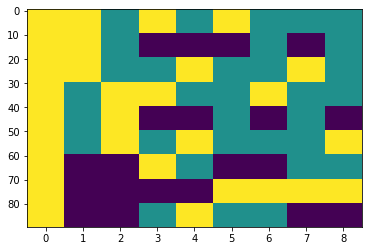

In [7]:
# use Patsy to construct the model above
model_matrix = patsy.dmatrix("group * language", df_2way)
# visualize model
plt.show(plt.imshow(model_matrix, aspect='auto'))
# use sum coding scheme for factors
plt.show(plt.imshow(patsy.dmatrix("C(group, Sum) * C(language, Sum)", df_2way), aspect='auto'))

# 2-way Repeated measures ANOVA in Python (within-subject factors)
Let's look at a different design, where we have repeated measures for each subject, which is common in psychological experiments. In this case we need to include random effects for each subject. We can conduct an ANOVA on such a design this using `mixedlm`. In the examples here, we are modeling a random intercept for each subject, but by passing the 're_formula' option, we can also include a random slope for each subject. If we only have a within-subject design, we can also use the `AnovaRM` function in Python, however, only fully balanced within-subject designs are supported here. One general limitation for the Python implementations is that *crossed random-effects are not supported*, so we can only specify one factor to model the random effects.

In the example below, I'm simulating data from a single-group design with two factors: All subjects performed three different tasks before and after a treatment. Note that in the data simulation, I'm introducing the factor sub_id which is unique for each subject and differs from the subject ID that we defined in the folder system (in combination with the 'group' string, the subject ID gives a unique identifier within the BIDS folder format).

In [8]:
# information on experimental design
subs_list = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10']
task_list = ['task1', 'task2', 'task3']
condition_list = ['pre', 'post']

# read data into dataframe
df_2way_rm = pd.DataFrame(columns=["sub_id", "task", "condition", "my_value"])
my_row = 0
# unique subject-ID as additional factor
sub_id = 0
for sub in subs_list:
    sub_id = sub_id + 1
    for ind_t, task in enumerate(task_list):
        for ind_c, con in enumerate(condition_list):
            # generate random value here as example
            my_val = np.random.normal(ind_t + ind_c, 1, 1)[0]
            df_2way_rm.loc[my_row] = [sub_id, task, con, my_val]
            my_row = my_row + 1

# conduct ANOVA using mixedlm
my_model_fit = smf.mixedlm("my_value ~ task * condition", df_2way_rm, groups=df_2way_rm["sub_id"]).fit()
# get random effects
my_model_fit.random_effects
# get fixed effects (no f-test implemented)
my_model_fit.summary()

/Users/neichert/miniconda3/envs/plotting/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Mixed Linear Model Regression Results
=========================================================================
Model:                   MixedLM       Dependent Variable:       my_value
No. Observations:        60            Method:                   REML    
No. Groups:              10            Scale:                    0.9879  
Min. group size:         6             Likelihood:               -83.2026
Max. group size:         6             Converged:                Yes     
Mean group size:         6.0                                             
-------------------------------------------------------------------------
                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------
Intercept                       0.889    0.314  2.828 0.005  0.273  1.505
task[T.task2]                   1.240    0.445  2.790 0.005  0.369  2.111
task[T.task3]                   2.452    0.445  5.516 0.000  1.581  3.323
condition[T.pre]               -0.466    0.445 -1.049 0.294 -1.337  0.405
task[T.task2]:condition[T.pre] -0.412    0.629 -0.655 0.512 -1.644  0.820
task[T.task3]:condition[T.pre] -1.049    0.629 -1.668 0.095 -2.281  0.183
Group Var                       0.000    0.169                           
=========================================================================

"""

In [9]:
# conduct ANOVA using AnovaRM
my_model_fit = AnovaRM(df_2way_rm, 'my_value', 'sub_id', within=['task', 'condition']).fit()
print(my_model_fit.anova_table)

                  F Value  Num DF  Den DF    Pr > F
task            14.983562     2.0    18.0  0.000148
condition       11.910377     1.0     9.0  0.007262
task:condition   1.676113     2.0    18.0  0.215013


# 4-way ANOVA with between-group and within-group factors (repeated measures)
If we wanted to conduct a mixed-model ANOVA that includes between-subject factors (group and language) and within-subject factors (task and condition), can do this using the `mixedlm` function, similar as shown above:

In [10]:
group_list = ['control','patient1','patient2']
language_list = ['English', 'German', 'French']
subs_list = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10']
task_list = ['task1', 'task2', 'task3']
condition_list = ['pre', 'post']

# read data into dataframe
df_full = pd.DataFrame(columns=["group", "language", "sub_id", "task", "condition", "my_value"])
my_row = 0
# unique subject-ID
sub_id = 0
for ind_g, group in enumerate(group_list):
    for ind_l, lan in enumerate(language_list):
        for sub in subs_list:
            sub_id = sub_id + 1
            for ind_t, task in enumerate(task_list):
                for ind_c, con in enumerate(condition_list):
                    # generate random value here as example
                    my_val = np.random.normal(ind_c + ind_t, 1, 1)[0]
                    df_full.loc[my_row] = [group, lan, sub_id, task, con, my_val]
                    my_row = my_row + 1

# conduct ANOVA using mixedlm
my_model_fit = smf.mixedlm("my_value ~ group * language * condition", df_full, groups=df_full["sub_id"]).fit()
# get random effects
my_model_fit.random_effects
# get fixed effects
my_model_fit.summary()

/Users/neichert/miniconda3/envs/plotting/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                             Mixed Linear Model Regression Results
================================================================================================
Model:                           MixedLM              Dependent Variable:              my_value 
No. Observations:                540                  Method:                          REML     
No. Groups:                      90                   Scale:                           1.7224   
Min. group size:                 6                    Likelihood:                      -913.2042
Max. group size:                 6                    Converged:                       Yes      
Mean group size:                 6.0                                                            
------------------------------------------------------------------------------------------------
                                                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------------
Intercept                                              2.088    0.240  8.716 0.000  1.619  2.558
group[T.patient1]                                     -0.242    0.339 -0.713 0.476 -0.906  0.423
group[T.patient2]                                      0.031    0.339  0.092 0.927 -0.633  0.695
language[T.French]                                    -0.073    0.339 -0.216 0.829 -0.737  0.591
language[T.German]                                    -0.333    0.339 -0.982 0.326 -0.997  0.331
condition[T.pre]                                      -0.645    0.339 -1.902 0.057 -1.309  0.020
group[T.patient1]:language[T.French]                  -0.043    0.479 -0.091 0.928 -0.983  0.896
group[T.patient2]:language[T.French]                   0.038    0.479  0.079 0.937 -0.901  0.977
group[T.patient1]:language[T.German]                   0.687    0.479  1.434 0.152 -0.252  1.626
group[T.patient2]:language[T.German]                   0.171    0.479  0.358 0.721 -0.768  1.111
group[T.patient1]:condition[T.pre]                    -0.211    0.479 -0.440 0.660 -1.150  0.728
group[T.patient2]:condition[T.pre]                    -0.501    0.479 -1.044 0.296 -1.440  0.439
language[T.French]:condition[T.pre]                   -0.193    0.479 -0.402 0.688 -1.132  0.747
language[T.German]:condition[T.pre]                   -0.330    0.479 -0.688 0.492 -1.269  0.610
group[T.patient1]:language[T.French]:condition[T.pre]  0.104    0.678  0.153 0.878 -1.224  1.432
group[T.patient2]:language[T.French]:condition[T.pre]  0.026    0.678  0.038 0.969 -1.302  1.354
group[T.patient1]:language[T.German]:condition[T.pre]  0.004    0.678  0.006 0.995 -1.324  1.332
group[T.patient2]:language[T.German]:condition[T.pre]  0.940    0.678  1.387 0.166 -0.389  2.268
Group Var                                              0.000    0.085                           
================================================================================================

"""

# Move from Python to R
As demonstrated above, most linear models can be succesfully be implemented in Python. The only limitation is that crossed-random effects are not supported. If this is needed, or for other reasons, we might want to run our analysis in R instead. An easy way to convert between both frameworks by writing out the dataframe to csv-format, which can be read by both Python and R. Here, we the data for two of the ANOVAs that we conducted above, to demonstrate that the results in R are exactly the same.

In [11]:
df_2way.to_csv('df_2way.csv', index=False)
df_full.to_csv('df_full.csv', index=False)

Continue from here with the Jupyter Notebook using the R kernel ....